
Congrats....again! Based off the amazing work you did on the classification model, you've been promoted to chief of all data scientists in Hollywood, your a total celebrity....among data scientists :).  

Your boss, head of the studio, has now asked you to build a model to predict gross revenue in order to help them decide which movies to invest in.

Once again, you would like to be able to explain the model to mere mortals but need a fairly robust and flexible approach so you've chosen to use decision trees to get started. 

In doing so...you leverage work you've done in the past to get the job done....you're a data scientist after all! 

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import graphviz
from sklearn.model_selection import train_test_split,RepeatedKFold,GridSearchCV
from sklearn.model_selection import train_test_split,GridSearchCV,RepeatedStratifiedKFold
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, get_scorer_names
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import plot_tree, DecisionTreeClassifier, export_graphviz
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import random
from numpy import log
from sklearn.tree import DecisionTreeRegressor, export_graphviz 

In [89]:
#1. Load the data
movie=pd.read_csv("../data/movie_metadata.csv")

#2 Ensure all the variables are classified correctly and collapse factor variables as needed.

In [90]:
movie.describe()

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
count,4993.000000,5028.000000,4939.000000,5020.000000,5036.000000,4.159000e+03,5.043000e+03,5043.000000,5030.000000,5022.000000,4.551000e+03,4935.000000,5030.000000,5043.000000,4714.000000,5043.000000
mean,140.194272,107.201074,686.509212,645.009761,6560.047061,4.846841e+07,8.366816e+04,9699.063851,1.371173,272.770808,3.975262e+07,2002.470517,1651.754473,6.442138,2.220403,7525.964505
std,121.601675,25.197441,2813.328607,1665.041728,15020.759120,6.845299e+07,1.384853e+05,18163.799124,2.013576,377.982886,2.061149e+08,12.474599,4042.438863,1.125116,1.385113,19320.445110
min,1.000000,7.000000,0.000000,0.000000,0.000000,1.620000e+02,5.000000e+00,0.000000,0.000000,1.000000,2.180000e+02,1916.000000,0.000000,1.600000,1.180000,0.000000
25%,50.000000,93.000000,7.000000,133.000000,614.000000,5.340988e+06,8.593500e+03,1411.000000,0.000000,65.000000,6.000000e+06,1999.000000,281.000000,5.800000,1.850000,0.000000
50%,110.000000,103.000000,49.000000,371.500000,988.000000,2.551750e+07,3.435900e+04,3090.000000,1.000000,156.000000,2.000000e+07,2005.000000,595.000000,6.600000,2.350000,166.000000
75%,195.000000,118.000000,194.500000,636.000000,11000.000000,6.230944e+07,9.630900e+04,13756.500000,2.000000,326.000000,4.500000e+07,2011.000000,918.000000,7.200000,2.350000,3000.000000
max,813.000000,511.000000,23000.000000,23000.000000,640000.000000,7.605058e+08,1.689764e+06,656730.000000,43.000000,5060.000000,1.221550e+10,2016.000000,137000.000000,9.500000,16.000000,349000.000000


#3 Check for missing variables and correct as needed.

#4 Guess what, you don't need to scale the data, because DTs don't require this to be done, they make local greedy decisions...keeps getting easier, go to the next step.

#5 Determine the variance of the target variable, is it normally distributed? If not, you may want to transform the target variable. Why might this be important?

#6 Split your data into test, tune, and train. (80/10/10)

In [91]:
#Steps 2-6 are done in the following function:
np.random.seed(1)
# Function drops unnecessary columns, fills in missing vals with mean, creates the score column with the binned imdb values, and creates the train/test/tune splits
def clean_split_data(df, target, train_size=0.80, tune_size=0.10, random_state=21):
    # Drop unnecessary columns
    df = df[['num_critic_for_reviews','actor_1_facebook_likes','gross','num_voted_users','cast_total_facebook_likes','num_user_for_reviews','budget','imdb_score','movie_facebook_likes']]
    # Fill missing values with mean for numeric columns
    df = df.fillna(df.mean(numeric_only=True))
    # Create target variable in this case Gross using the log for better distribution
    df[target] = np.log(df[target] + 1)
    X = df.drop(columns=target)
    y = df[target]
    
    # Calculate prevalence of the score
    variance = y.value_counts().var()
    print("Variance of log Gross:", variance)
    
    # Split data into training and testing sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=train_size, random_state=random_state)
    
    # Split the temporary set into tuning and testing sets
    X_tune, X_test, y_tune, y_test = train_test_split(X_temp, y_temp, train_size=tune_size, random_state=random_state+28)
    
    return X_train, X_tune, X_test, y_train, y_tune, y_test

# Use the function to split the movie data
X_train, X_tune, X_test, y_train, y_tune, y_test = clean_split_data(movie, 'gross')

Variance of log Gross: 193.20390310010393


It is important to transform the target variable because if it is not normally distributed, large numbers and outliers can skew results leading to inaccurate predictions.

#7 Create the kfold object for cross validation.

In [92]:
# k fold object creation
kf =RepeatedKFold(n_splits=10,n_repeats =5, random_state=42)

#8 Create the scoring metric (several measures) you will use to evaluate your model and choose a hyperparamater to optimize.

In [93]:
#setting scoring metrics and param for grid search
scoring = ['neg_mean_squared_error','r2','neg_mean_absolute_error']
#param = {"min_samples_leaf":[1,2,3,4,5,6,7,8,9,10]}
param={"min_samples_leaf":[1,2,3,4,5,6,7,8,9,10], 'max_depth':[1,2,3,4,5,6,7,8,9,10], "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90]}
           

#9 Build the regression tree object. 

In [ ]:
reg=DecisionTreeRegressor(random_state=30)

search = GridSearchCV(reg, param, scoring=scoring, n_jobs=-1, cv=kf,refit='r2')

#10 Fit the model to the training data.

In [95]:
model = search.fit(X_train, y_train)

#11 Explore the results of the model. Print the output of the grid search. What is the best parameter and score?

DecisionTreeRegressor(max_depth=5, max_leaf_nodes=40, min_samples_leaf=7,
                      random_state=30)


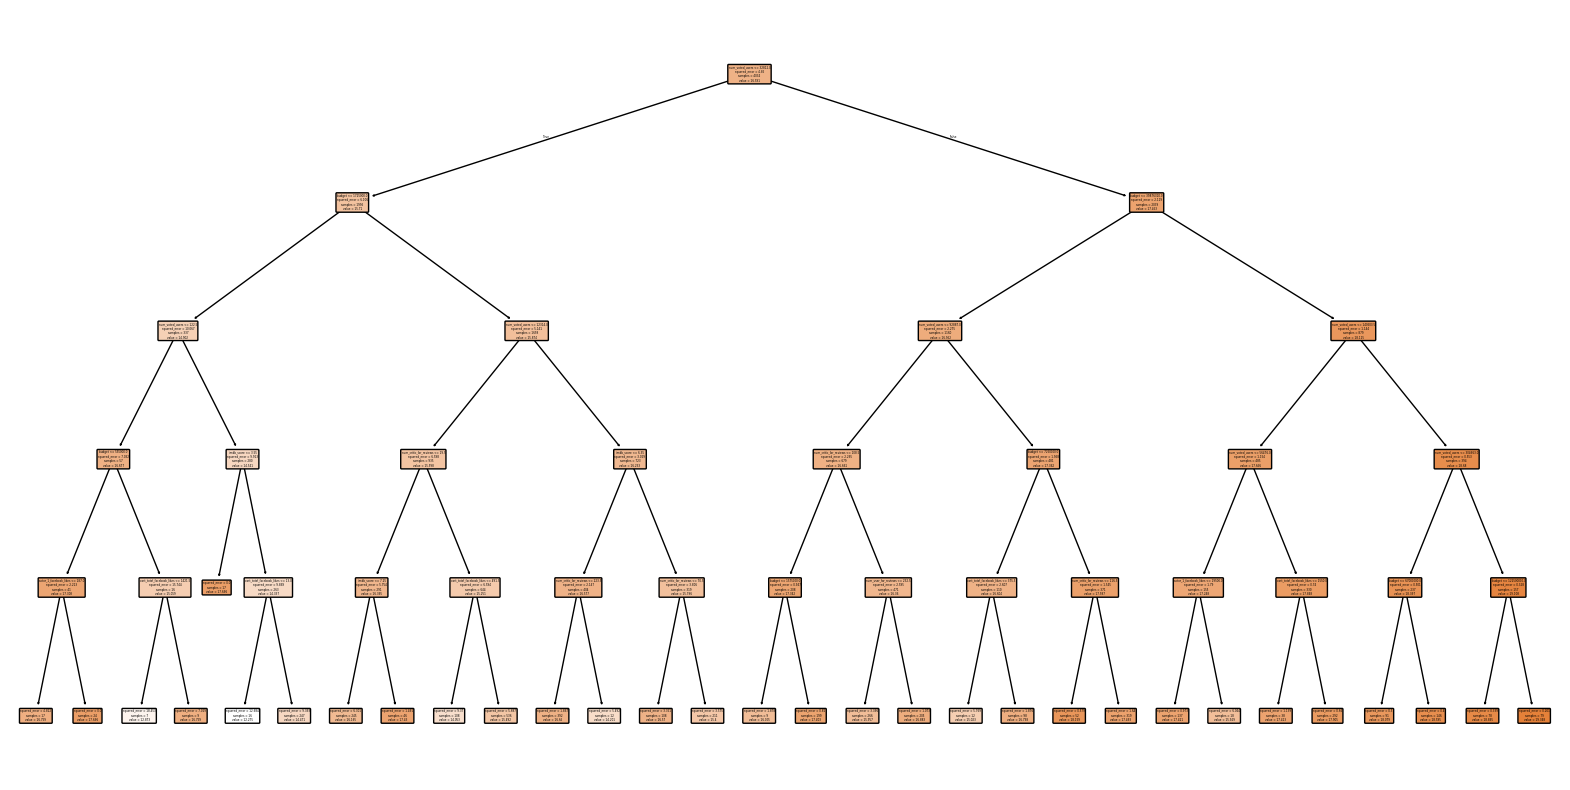

In [96]:
best= model.best_estimator_
print(best)

plt.figure(figsize=(20,10))
plot_tree(best, feature_names=X_train.columns, class_names=y_train.unique(), filled=True, rounded=True)
plt.show()

In [97]:
mean_sq_err = np.sqrt(abs(model.cv_results_['mean_test_neg_mean_squared_error']))
#nothing needs to be done for r2, it is the same
r2= model.cv_results_['mean_test_r2']
#Have negative mean absolute error so need to take absolute value
mae= abs(model.cv_results_['mean_test_neg_mean_absolute_error'])

#Get standard deviations as well...
SDmse =  model.cv_results_['std_test_neg_mean_squared_error']
SDr2= model.cv_results_['std_test_r2']
SDmae= model.cv_results_['std_test_neg_mean_absolute_error']

#Parameter:
depth= np.unique(model.cv_results_['param_min_samples_leaf']).data

#Build DataFrame:
final_model = pd.DataFrame(list(zip(depth, mean_sq_err, r2,mae, SDmse,SDr2,SDmae)),
               columns =['depth','rmse','r2','mae',"rmseSD",'r2SD','maeSD'])

#Let's take a look
final_model.style.hide(axis="index")

depth,rmse,r2,mae,rmseSD,r2SD,maeSD
1,2.030138,0.148030,1.489707,0.387875,0.032726,0.062497
2,2.030138,0.148030,1.489707,0.387875,0.032726,0.062497
3,2.030138,0.148030,1.489707,0.387875,0.032726,0.062497
4,2.030138,0.148030,1.489707,0.387875,0.032726,0.062497
5,2.030138,0.148030,1.489707,0.387875,0.032726,0.062497
6,2.030138,0.148030,1.489707,0.387875,0.032726,0.062497
7,2.030138,0.148030,1.489707,0.387875,0.032726,0.062497
8,2.030138,0.148030,1.489707,0.387875,0.032726,0.062497
9,2.030138,0.148030,1.489707,0.387875,0.032726,0.062497
10,2.030138,0.148030,1.489707,0.387875,0.032726,0.062497


The best parameter is, and the best score is rmseSD

#12 Which variables appear to be contributing the most (variable importance) 

                           importance
num_voted_users              0.604218
budget                       0.174116
num_critic_for_reviews       0.089187
cast_total_facebook_likes    0.055833
imdb_score                   0.054424
num_user_for_reviews         0.015371
actor_1_facebook_likes       0.006851
movie_facebook_likes         0.000000
Axes(0.125,0.11;0.775x0.77)


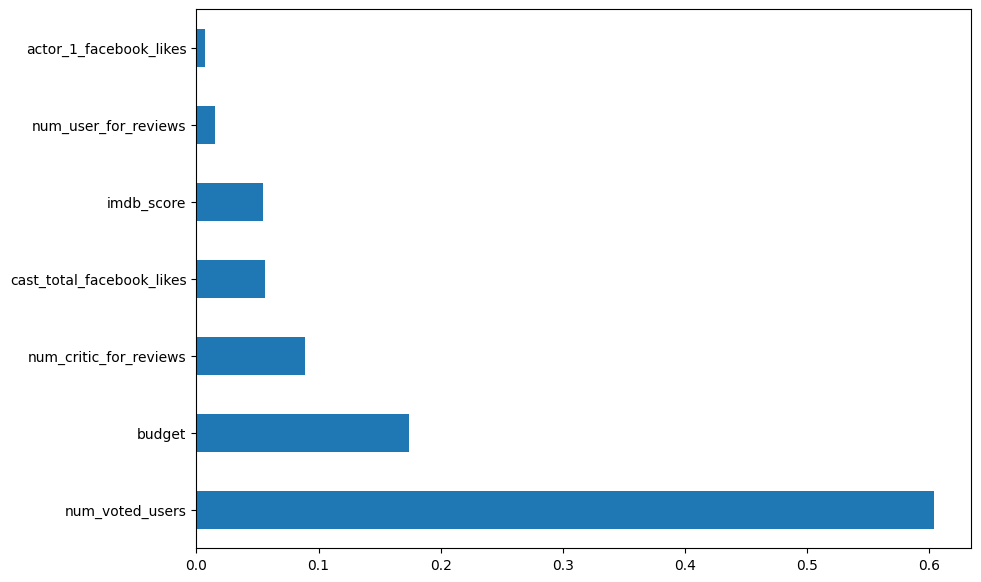

In [98]:
varimp=pd.DataFrame(best.feature_importances_,index = X_train.columns,columns=['importance']).sort_values('importance', ascending=False)
print(varimp)

plt.figure(figsize=(10,7))
print(varimp.importance.nlargest(7).plot(kind='barh'))

#13 Create a model object using the best model hyperparameter value from the trained regression tree. 

In [99]:
best 

DecisionTreeRegressor(max_depth=5, max_leaf_nodes=40, min_samples_leaf=7,
                      random_state=30)

#14 Using the best model predict on the tune data and print out the results.

In [112]:

tune_pred = best.predict(X_tune)


#15 How does the model perform on the tune data as compared to the training data?

In [114]:
print(best.predict(X_train))

[17.49344652 15.49238013 16.16467996 ... 15.49238013 19.34809413
 17.90456065]


#16 What five movies are predicted to have the lowest gross revenue from the tune set? 

In [115]:
tune_pred = best.predict(X_tune)
tune_results = pd.DataFrame({'predicted_score': tune_pred}, index=X_tune.index)
tune_results = tune_results.merge(movie[['movie_title']], left_index=True, right_index=True)
tune_results = tune_results.merge(movie[['gross']], left_index=True, right_index=True)

# Sort the DataFrame by the 'gross' column in ascending order
low_gross_movies = tune_results.sort_values(by='gross', ascending=True)

# Select the top 5 rows
five_movies = low_gross_movies.head(5)

print("Lowest gross Revenue Movies:")
print(five_movies[['movie_title', 'gross']])

Lowest gross Revenue Movies:
                                            movie_title     gross
4750  Finishing the Game: The Search for a New Bruce...   52850.0
4713                                     Water & Power    79043.0
3418                                         Pathology   108662.0
1323                                      The Warlords   128978.0
4587  Once in a Lifetime: The Extraordinary Story of...  144431.0


#17 As a data scientist you are always looking to improve your results. What are some ideas you have to improve the model? Have you ask...WHAT IF?!

#18 Experiment using your what if ideas (two is fine). Did the model improve? If so, how much? If not, what did you learn? (You don't need to include all the "what if" code just speak to what you tried and what you learned).

#19 Use the best model to predict on the test data and print out the evaluation results.

In [117]:
best_pred = best.predict(X_test)
test_results = pd.DataFrame({'predicted_score': best_pred}, index=X_test.index)
test_results = test_results.merge(movie[['movie_title']], left_index=True, right_index=True)
test_results = test_results.merge(movie[['gross']], left_index=True, right_index=True)
# Sort the DataFrame by the 'gross' column in ascending order
low_gross_movies = test_results.sort_values(by='gross', ascending=True)

# Select the top 5 rows
five_movies = low_gross_movies.head(5)

print("Lowest gross Revenue Movies:")
print(five_movies[['movie_title', 'gross']])


Lowest gross Revenue Movies:
              movie_title   gross
3242  The Oxford Murders   3607.0
5037           Newlyweds   4584.0
4604            Sparkler   5494.0
4315           Eden Lake   5824.0
4516    Dead Man's Shoes   6013.0


#20 Does the model perform well on the test data when compared to the training and tune data? Why or why not? 

#21 Where are the errors occurring in your predictions? Are they systematic or random? In either case, what are the implications of this?

#22 Summarize what you learned along the way and make recommendations on how this could be used moving forward, being careful not to over promise.